In [2]:
import os, gc, glob, numpy as np, pandas as pd, regex as re, time, \
    warnings, numba as nb, joblib as jl, json, seaborn as sns, scipy.stats, \
    matplotlib.colors as mplcol, matplotlib.cm as cm
import matplotlib.pyplot as plt, matplotlib as mpl
import skimage.transform, skimage.segmentation
from tqdm import tqdm_notebook as tqdm
from plotnine import *
from scipy.cluster import hierarchy
from scipy.stats import variation
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import warnings; warnings.filterwarnings("ignore")

In [3]:
# Load polarpos data, and accompanying HHMM predictions
#fnames = glob.glob('Y:/wavelet/hhmm-results/*regimes_12minrun_manuallabels_5fold.*.resave.pickle')
fnames = glob.glob('Y:/wavelet/hhmm-results/*regimes_12minrun_manuallabels_5fold.pickle')
fnames = [x for x in fnames if not 'idxmapping' in x]
fnames = [fnames[5],]
fnames

['Y:/wavelet/hhmm-results\\5regimes_12minrun_manuallabels_5fold.pickle']

In [4]:
t0 = time.time()

gc.collect()

def loadPickle(fn):
    try:
        gc.disable()
        return jl.load(fn)
        gc.enable()
    except Exception as e:
        print(fn, str(e))
        return None
    
data = [loadPickle(fn) for fn in tqdm(fnames)]
data = [x for x in data if x is not None]

t1 = time.time()

In [5]:
def loadData(modelIdx, modelRepIdx, modelRecIdx):
    def loadJSON(x):
        if os.path.exists(x):
            with open(x, 'r') as f:
                return json.load(f)
        else:
            return None

    # Load position/orientation data
    fnamePos = glob.glob(os.path.abspath(os.path.join(os.path.dirname(
        data[modelIdx]['fnames'][modelRecIdx][0]), '../croprot/*dlc_position_orientation.npy')))[0]

    # Load recording info
    fnameRecInfo = os.path.join(os.path.dirname(os.path.dirname(fnamePos)), 'recording.json')
    recordingInfo = loadJSON(fnameRecInfo)

    # Create short name
    fnamesShort = re.search('^Z:/.*/(.*)/.*/.*$', fnamePos.replace('\\', '/')).group(1)

    # Fill in missing stage information, if necessary
    s = recordingInfo
    s['fname'] = fnamePos

    # Does this recording.json file specify stage ranges, or starting points?
    if isinstance(s['stages']['protoweb'], list):
        for st in s['stages']:
            try:
                if not isinstance(s['stages'][st][0], list):
                    s['stages'][st] = [s['stages'][st], ]
            except:
                s['stages'][st] = []
    else:
        # Add the end of the recording
        a = np.load(s['fname'], mmap_mode='r')
        s['stages']['end'] = a.shape[0]

        if 'stabilimentum' in s['stages']:
            if s['stages']['stabilimentum'] >= 0:
                pass
            else:
                s['stages']['stabilimentum'] = s['stages']['end']
        else:
            s['stages']['stabilimentum'] = s['stages']['end']

        # Now convert to ranges
        s['stages']['protoweb'] = [[s['stages']['protoweb'], s['stages']['radii']],]
        s['stages']['radii'] = [[s['stages']['radii'], s['stages']['spiral_aux']],]
        s['stages']['spiral_aux'] = [[s['stages']['spiral_aux'], s['stages']['spiral_cap']],]
        s['stages']['spiral_cap'] = [[s['stages']['spiral_cap'], s['stages']['stabilimentum']],]
        s['stages']['stabilimentum'] = [[s['stages']['stabilimentum'], s['stages']['end']],]
        del s['stages']['end']

    # Convert to indices used in analysis
    arrIdx = np.load(fnamePos.replace('_position_orientation.npy','_abs_filt_interp_mvmt_noborder.idx.npy'))
    for st in s['stages']:
        for k in range(len(s['stages'][st])):
            for m in range(2):
                s['stages'][st][k][m] = np.argmin(np.abs(np.argwhere(arrIdx).T[0] - s['stages'][st][k][m]))
    
    # Load original data
    arr = np.load(fnamePos)

    # Subset by index
    arrIdx = np.load(fnamePos.replace('_position_orientation.npy',
                                      '_abs_filt_interp_mvmt_noborder.idx.npy'))
    arr = arr[arrIdx,:]
    
    # Mapping data
    arrIdxMapping = jl.load(fnames[modelIdx].replace(re.search('([.0-9]*\\.pickle)$', 
        fnames[modelIdx]).group(0), '.idxmapping.pickle').replace('.resave', '').replace('.1', ''))
    
    # Re-duplicate states
    states = data[modelIdx]['models'][modelRepIdx]['model-fit-states'][modelRecIdx]
    statesMapped = np.array([(-1 if x == -1 else states[x]) for x in arrIdxMapping[modelRecIdx]], dtype=int)
    
    # Split states by stage of web-building
    statesMappedByStage = {}
    for st in recordingInfo['stages']:
        idxStage = np.full(statesMapped.shape[0], False, dtype=np.bool)
        for k in recordingInfo['stages'][st]:
            idxStage[k[0]:k[1]] = True
        statesMappedByStage[st] = statesMapped[idxStage]
    
    # Done
    return statesMappedByStage['spiral_cap'], data[modelIdx]['clusterLabelsUniqueUnified']

In [6]:
allData = [loadData(0, 0, i) for i in tqdm(range(21))]

In [7]:
_data = []
clusterLabelsUnique = allData[0][1]

for arrClustersFilt, _ in tqdm(allData, leave=False):
    # Which events have anterior bend-abdomen behavior?
    bendAbdomenIDs = [i for i, x in enumerate(clusterLabelsUnique) if '/bend-abdomen' in x or x == 'bend-abdomen']

    # Find occurrences
    eventBendAbdomenAll = np.argwhere(np.isin(arrClustersFilt, bendAbdomenIDs))[:,0]
    eventBendAbdomen = eventBendAbdomenAll[np.hstack((np.diff(eventBendAbdomenAll), 1)) != 1]
    timeSinceBendAbdomen = np.full(arrClustersFilt.shape[0], np.nan, dtype=np.float64)

    # Mark frames with respect to the most recent abdomen bending occurrence
    timeSinceBendAbdomen[eventBendAbdomen] = 0
    for i in range(1, timeSinceBendAbdomen.size):
        if np.isnan(timeSinceBendAbdomen[i]) and not np.isnan(timeSinceBendAbdomen[i-1]):
            timeSinceBendAbdomen[i] = timeSinceBendAbdomen[i-1] + 1

    # Mark abdomen bending time index with respect to last occurrence (so -10 is 10 frames before last occurrence)
    for i in range(timeSinceBendAbdomen.size-1, 0, -1):
        if i in eventBendAbdomenAll:
            timeSinceBendAbdomen[i] = timeSinceBendAbdomen[i+1] - 1

    # Fill last remaining NAs
    timeSinceBendAbdomen[np.isnan(timeSinceBendAbdomen)] = 1000000
    timeSinceBendAbdomen = timeSinceBendAbdomen.astype(np.int64)

    # Compute time-since-abdomen
    data = []
    clUnique = np.unique(arrClustersFilt)
    for xi, x in enumerate(clUnique):
        _timeSinceBendAbdomen = timeSinceBendAbdomen[arrClustersFilt == x]
        _timeSinceBendAbdomen = _timeSinceBendAbdomen[_timeSinceBendAbdomen < 300]
        if np.sum(arrClustersFilt == x) > 0:
            filtID = np.max(arrClustersFilt[arrClustersFilt == x])
            if filtID >= 0:
                if _timeSinceBendAbdomen.size >= 500:
                    for t in _timeSinceBendAbdomen:
                        data.append((filtID, clusterLabelsUnique[filtID], t))

    data = pd.DataFrame(data, columns=['clusterID', 'cluster', 't'])
    _data.append(data)
    
tbl = pd.concat(_data)

In [8]:
clUnique = tbl.clusterID.unique()
clUnique

array([10, 11, 12, 21, 23, 26, 29, 41, 43, 14, 30, 17, 25], dtype=int64)

In [9]:
# Compute average order of every event
def getRank(x):
    #return -np.median(x[x>=0])
    a, b = np.histogram(x, bins=350, range=(-100, 300))
    b = 0.5 * (b[1:] + b[:-1])
    return -b[np.argmax(a)]

relTime = np.array([getRank(tbl.t[tbl.clusterID == x]) for x in clUnique]).astype(int)
relTime = np.argsort(relTime)

In [10]:
tblHistogram = []
for clusterID in tbl.clusterID.unique():
    d = tbl.t[tbl.clusterID == clusterID]
    cluster = tbl.cluster[tbl.clusterID == clusterID].values[0]
    a, b = np.histogram(d, range=(-100, 300), bins=400)
    b = 0.5 * b[1:] + 0.5 * b[:-1]
    clUniqueIdx = relTime.tolist().index(clUnique.tolist().index(clusterID))
    for count, dt in zip(a, b):
        tblHistogram.append((cluster, clusterID, dt, count, clUniqueIdx))

tblHistogram = pd.DataFrame(tblHistogram, columns=['cluster', 'clusterID', 'dt', 'count', 'clusterSortPos'])
tblHistogram.loc[:,'countMax'] = tblHistogram.groupby('clusterID').transform('max').loc[:,'count'].values
tblHistogram.loc[:,'countRel'] = tblHistogram.loc[:,'count'] / tblHistogram.countMax
tblHistogram.loc[:,'countSum'] = tblHistogram.groupby('clusterID').transform('sum').loc[:,'count'].values

In [11]:
tblHistogram.loc[:,'y'] = tblHistogram.countRel + tblHistogram.clusterSortPos

In [12]:
COLORS_CLUSTERS = {
 'walk': '#0066b5',
 'one-leg-after-other': '#215440',
 'extrude-slow': '#f0e442',
 'extrude': '#009e73',
 'left-leg': '#e69f00',
 'both-legs': '#61133e',
 'stationary': '#000000',
 'stationary-posterior': '#666666',
 'stationary-anterior': '#666666',
 'stabilimentum': '#cc79a7',
 'noisy': None,
 'right-leg': '#6dc5f7',
 'bend-abdomen': '#d55e00'
}

COLORS_CLUSTERS = {x:(y+'cc' if y is not None else None) for x, y in COLORS_CLUSTERS.items()}

In [13]:
import colorcet

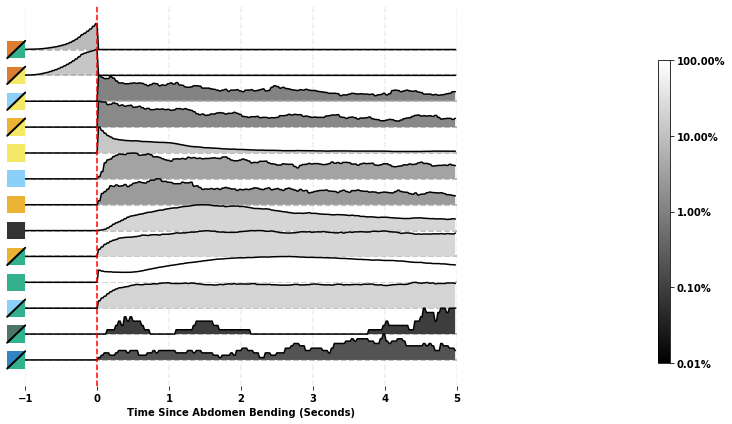

In [53]:
cmap = 'gray'

fig, ax = plt.subplots(1, 1, figsize=(8,6))

for clusterID in tblHistogram.clusterID.unique():
    d = tblHistogram[tblHistogram.clusterID == clusterID]
    d = d[d.dt < 250]
    lbl = d.cluster.values[0]
    
    y = 0.75 * (d.countRel.values / np.max(d.countRel.values.max())) + d.clusterSortPos.values * 0.75
    
    val = np.clip((np.log10(d.countSum.values[0] / tblHistogram.countSum.max()) + 4)/4, 0, 1)
    col = cm.get_cmap(cmap)(val)
    
    ax.plot(np.arange(-100, 250) * 0.02, y, color='black')
    ax.plot(np.array([-100, 250]) * 0.02, [y[0], y[0]], color='#aaaaaa', linestyle='--', zorder=-100)
    ax.fill_between(
        np.arange(-100, 250) * 0.02, 
        y, d.clusterSortPos.values * 0.75, 
        facecolor=col, edgecolor=None, linewidth=2, 
        zorder=-10 * d.clusterSortPos.values[0])
    
    # Option 1: Display text
    #ax.text(5.2, y[0], lbl)
    
    # Option 2: Display colored box
    k = y[0]
    m = 0
    w = 0.5
    h = 0.25
    if '/' not in lbl:
        ax.add_artist(Polygon([[m-1, k + w/2], [m-(1+h), k + w/2], [m-(1+h), k - w/2], [m-1, k - w/2]], 
                              clip_on=False, facecolor=COLORS_CLUSTERS[lbl]))
    else:
        c1 = COLORS_CLUSTERS[lbl[:lbl.find('/')]]
        c2 = COLORS_CLUSTERS[lbl[(lbl.find('/')+1):]]
        ax.add_artist(Polygon([[m-1, k + w/2],[m-(1+h), k + w/2], [m-(1+h), k - w/2]], 
                              clip_on=False, facecolor=c2, edgecolor=None))
        ax.add_artist(Polygon([[m-1, k + w/2],[m-1, k - w/2], [m-(1+h), k - w/2]], 
                              clip_on=False, facecolor=c1, edgecolor=None))
        ax.plot([m-(1+h), m-1], [k-w/2, k+w/2], color='black', 
                linewidth=2, zorder=100, clip_on=False, solid_capstyle='round')

# Axis labels, etc.
for i in range(-1, 6):
    ax.axvline(x=i, color='red' if i == 0 else '#eeeeee', linestyle='--', zorder=100 if i == 0 else -10000)

ax.set_xlim(-1, 5)
ax.set_xlabel('Time Since Abdomen Bending (Seconds)')

# Figure layout, etc.
#ax.axis('equal')
ax.set_frame_on(False)
ax.axes.get_yaxis().set_visible(False)
fig.tight_layout()

# Add colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.15, 0.15, 0.02, 0.7])

_ticklabels = [0.0001, 0.001, 0.01, 0.1, 1.0]
_ticks = [np.clip((np.log10(tl) + 4)/4, 0, 1) for tl in _ticklabels]
cb = mpl.colorbar.ColorbarBase(
    cbar_ax, cmap=cm.get_cmap(cmap),
    orientation='vertical', 
    ticks=_ticks)

cb.ax.set_yticklabels(['{:.2f}%'.format(100 * x) for x in _ticklabels])

# Done
fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_4b.pdf', bbox_inches='tight')